Le but de ce projet est d’analyser des données single-cell RNA-seq pour identifier differents groupes de cellules et observer leurs profils d’expression génique avec des outils bioinformatiques.

In [39]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [40]:
adata = sc.datasets.pbmc3k()
adata.var_names_make_unique()

print(adata.shape)

(2700, 32738)


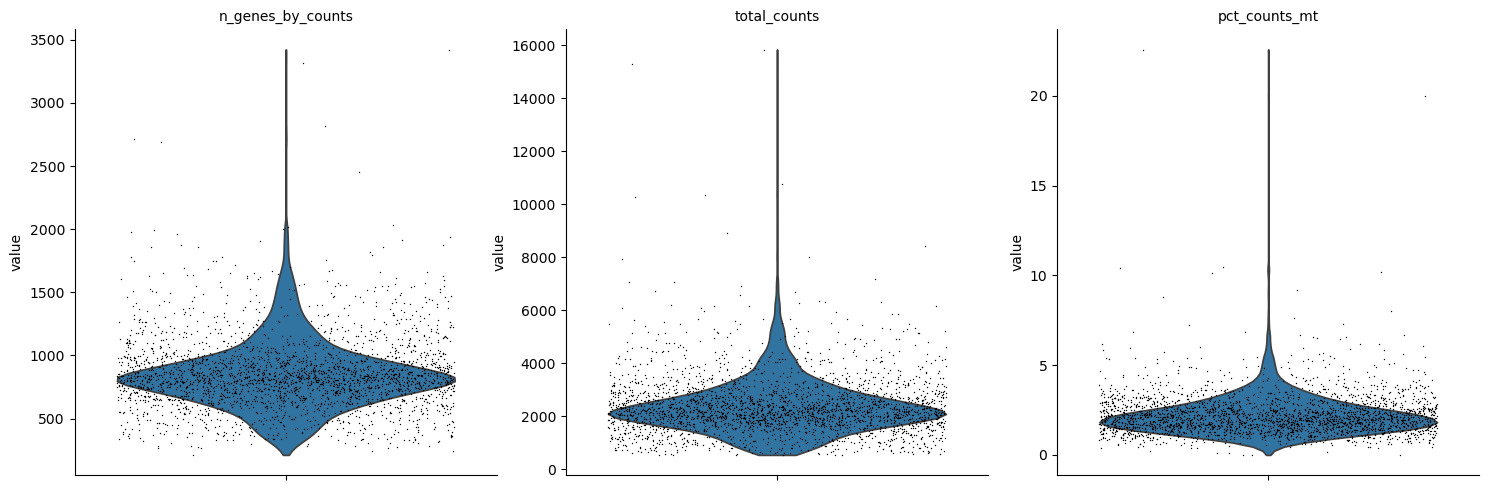

In [41]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4,
    multi_panel=True
)

In [42]:
adata = adata[adata.obs.n_genes_by_counts > 200, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [43]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

/var/folders/y4/131d089n69q7px5pjl6r6jz80000gn/T/ipykernel_55498/1876471178.py:1: UserWarning: Received a view of an AnnData. Making a copy.
  sc.pp.normalize_total(adata, target_sum=1e4)


In [44]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]
adata = adata[:, adata.var.highly_variable]

print(adata.shape)

(2643, 2000)


In [45]:
sc.pp.scale(adata, max_value=10)

/opt/anaconda3/lib/python3.13/functools.py:934: UserWarning: Received a view of an AnnData. Making a copy.
  return dispatch(args[0].__class__)(*args, **kw)
/opt/anaconda3/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


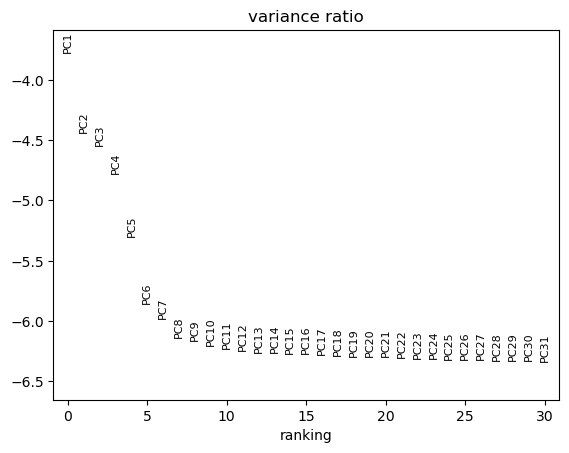

In [46]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

/var/folders/y4/131d089n69q7px5pjl6r6jz80000gn/T/ipykernel_55498/1801194425.py:2: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(adata, resolution=0.5)


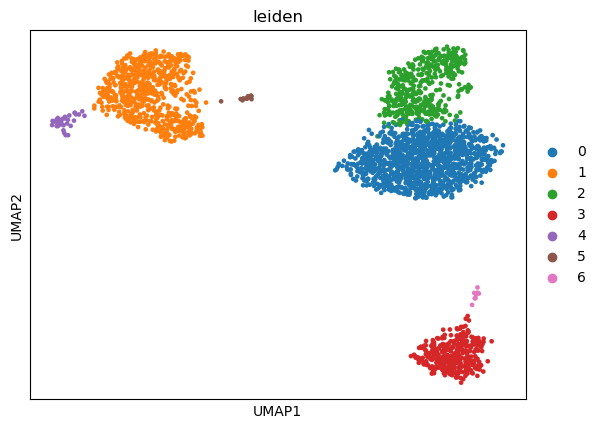

In [47]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata, resolution=0.5)
sc.tl.umap(adata)
sc.pl.umap(adata, color='leiden')

Sur le graphique UMAP, on voit 6 clusters de cellules séparés. Cela montre que les cellules ne sont pas toutes identiques, car elles ont des profils d’expression génique differents. Le cluster 0 semble contenir plus de cellules que les autres, ce qui peut indiquer un type cellulaire plus présent dans l’échantillon.

In [48]:
adata.obs.head()

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,leiden
index,,,,,,,,,,,,
AAACATACAACCAC-1,781,6.661855,2421.0,7.792349,47.748864,63.279637,74.969021,88.393226,73.0,4.304065,3.015283,0
AAACATTGAGCTAC-1,1352,7.210080,4903.0,8.497807,45.502753,61.023863,71.813176,82.622884,186.0,5.231109,3.793596,3
AAACATTGATCAGC-1,1131,7.031741,3149.0,8.055158,41.314703,53.794856,65.449349,79.961893,28.0,3.367296,0.889171,0
AAACCGTGCTTCCG-1,960,6.867974,2639.0,7.878534,39.029936,52.898825,66.691929,82.569155,46.0,3.850147,1.743085,1
AAACCGTGTATGCG-1,522,6.259581,981.0,6.889591,44.852192,55.657492,67.176351,97.757390,12.0,2.564949,1.223242,2


In [49]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

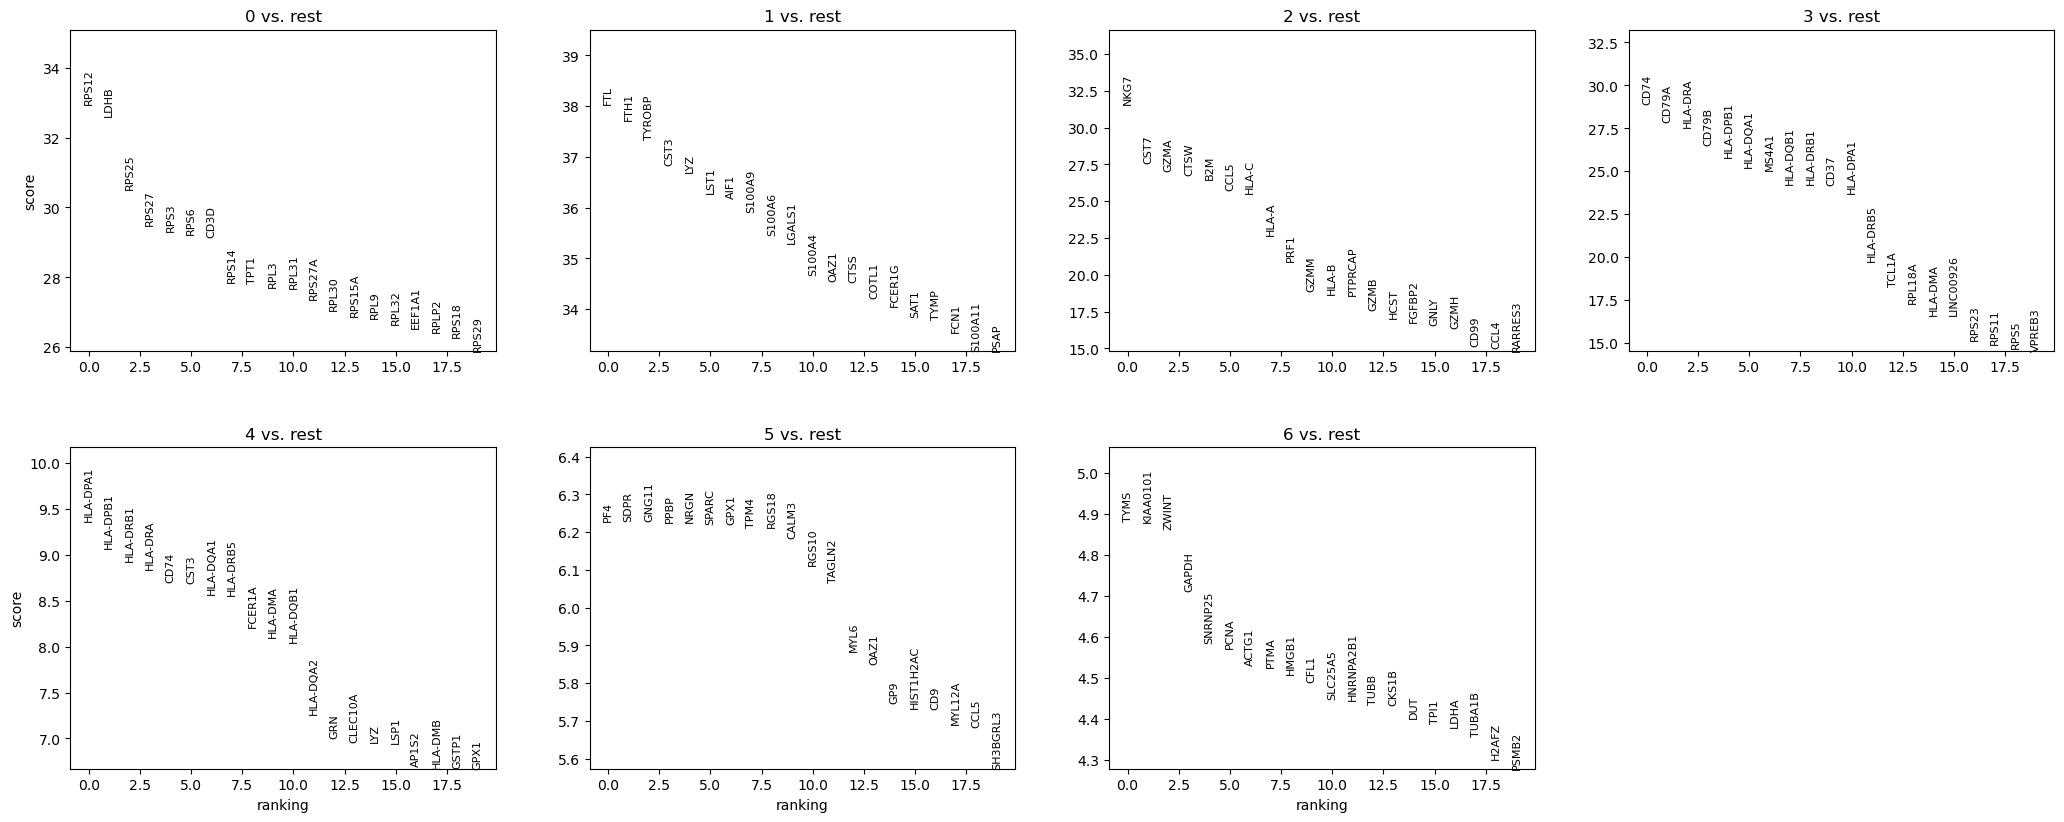

In [50]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

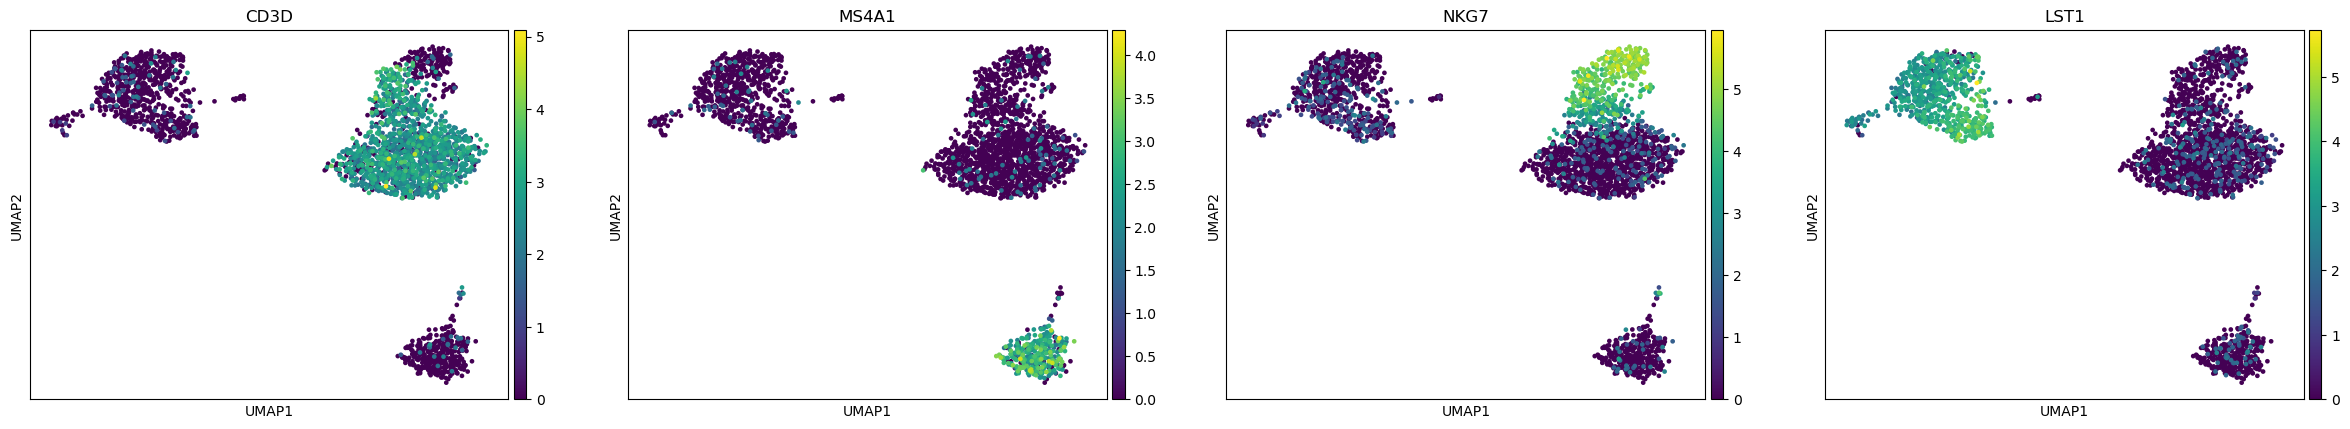

In [51]:
sc.pl.umap(
    adata,
    color=['CD3D', 'MS4A1', 'NKG7', 'LST1'],
)

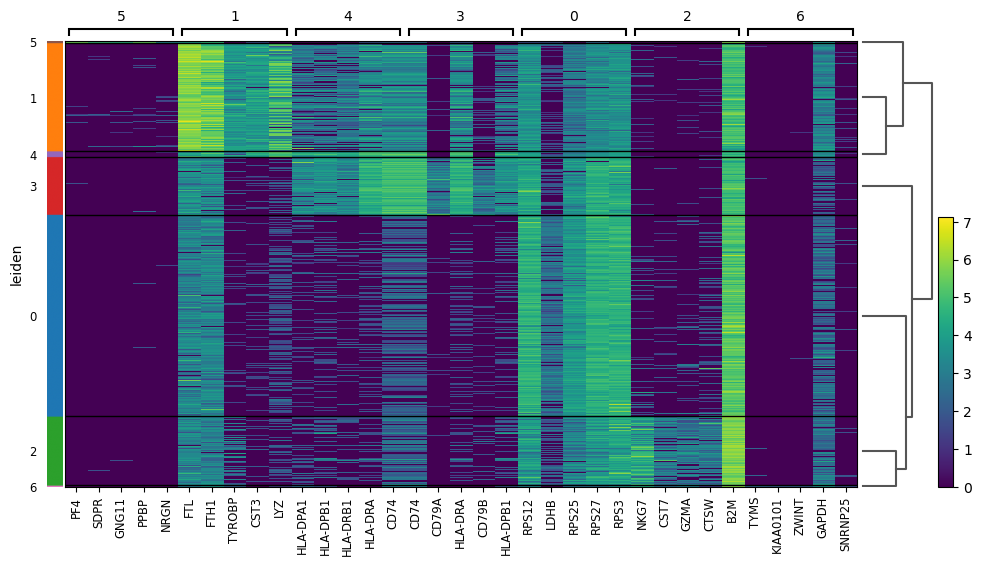

In [52]:
sc.pl.rank_genes_groups_heatmap(
    adata,
    n_genes=5,
    groupby="leiden",
    cmap="viridis"
)

In [53]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

for group in groups:
    print(f"\nCluster {group}")
    genes = result['names'][group][:5]
    pvals = result['pvals_adj'][group][:5]
    for g, p in zip(genes, pvals):
        print(g, p)


Cluster 0
RPS12 6.299307954522893e-234
LDHB 6.223800190913354e-229
RPS25 6.63845302731928e-201
RPS27 1.0248994648493312e-187
RPS3 2.3269969001335093e-185

Cluster 1
FTL 0.0
FTH1 0.0
TYROBP 3.956657004365938e-301
CST3 5.031622861251644e-293
LYZ 3.95489986868131e-291

Cluster 2
NKG7 5.923290815108352e-215
CST7 6.824758751433991e-163
GZMA 9.695712553927542e-157
CTSW 9.30686634156046e-154
B2M 6.918684023603049e-151

Cluster 3
CD74 1.6633237061347763e-179
CD79A 9.205504319316848e-167
HLA-DRA 2.3136727317587022e-163
CD79B 4.1093059728389076e-151
HLA-DPB1 5.580896975902192e-143

Cluster 4
HLA-DPA1 2.5100372501112753e-16
HLA-DPB1 1.9085883102986e-15
HLA-DRB1 4.746601653063343e-15
HLA-DRA 7.759701799903532e-15
CD74 1.9742219755569985e-14

Cluster 5
PF4 1.84941436703637e-06
SDPR 1.84941436703637e-06
GNG11 1.84941436703637e-06
PPBP 1.84941436703637e-06
NRGN 1.84941436703637e-06

Cluster 6
TYMS 0.012719505348553097
KIAA0101 0.012719505348553097
ZWINT 0.012719505348553097
GAPDH 0.02021480591617625

Sur la heatmap, on observe que certains gènes sont beaucoup plus exprimés dans certains clusters que dans d’autres. Cela montre que les cellules ne sont pas toutes identiques et qu’il existe plusieurs populations cellulaires avec des profils d’expression différents.

Les gènes affichés ont été sélectionnés grâce au test de Wilcoxon, avec une correction des p-values (p_adj < 0.05), ce qui permet de s’assurer que les différences observées ne sont pas dues au hasard.

Chaque cluster présente donc une signature génétique propre, avec des gènes marqueurs spécifiques. Cela confirme l’hétérogénéité cellulaire du jeu de données et permet d’identifier différentes sous-populations cellulaires.

D’un point de vue statistique, les gènes affichés ont été sélectionnés avec le test de Wilcoxon, puis les p-values ont été corrigées (p_adj < 0.05).
Cette correction est importante en scRNA-seq, car on teste des milliers de gènes en même temps. Plus on fait de tests, plus on risque d’avoir des résultats faux positifs juste par hasard.

La correction permet donc de limiter ce risque et de garder uniquement les gènes dont la différence d’expression est vraiment significative.

De plus, la sélection des gènes hautement variables en amont permet de réduire le bruit et d’améliorer la séparation des clusters lors de la PCA et du clustering.